In [394]:
using Gurobi, JuMP, DataFrames, CSV
using Statistics
using MLBase
using JuMP, Ipopt
using StatsBase
using Juniper
using Shuffle

In [513]:
#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame)

# Only keep rows where sold ==1
df = df[df[!,"sold"] .== 1, :];

#Keep the rows where price is between 5th and 95th percentile
df = df[df[!,"sales_price"] .> quantile(df[!,"sales_price"], 0.05), :]
df = df[df[!,"sales_price"] .< quantile(df[!,"sales_price"], 0.95), :];

#Drop the column sold
df = df[:, Not(:sold)]

#Drop the rows where Area is 0
df = df[df[!,"area"] .> 0, :];

#Define target variable 
y = df[!,"sales_price"]
X= df[:, Not(:sales_price)];

size(df)

(36642, 113)

In [477]:
#Create non linear transformations for height, width, aspect_ratio, low_estimate, and high estimate, area 
#first, square the columns, name it the same but _2
X[!,"height_sqaured"] = X[!,"height"].^2
X[!,"width_sqaured"] = X[!,"width"].^2
X[!,"aspect_ratio_sqaured"] = X[!,"aspect_ratio"].^2
X[!,"low_estimate_sqaured"] = X[!,"low_estimate"].^2
X[!,"high_estimate_sqaured"] = X[!,"high_estimate"].^2
X[!,"area_sqaured"] = X[!,"area"].^2

#Now square root
X[!,"height_root"] = sqrt.(X[!,"height"])
X[!,"width_root"] = sqrt.(X[!,"width"])
X[!,"aspect_ratio_root"] = sqrt.(X[!,"aspect_ratio"])
X[!,"low_estimate_root"] = sqrt.(X[!,"low_estimate"])
X[!,"high_estimate_root"] = sqrt.(X[!,"high_estimate"])
X[!,"area_root"] = sqrt.(X[!,"area"])

#Now take the log
X[!,"height_log"] = log.(X[!,"height"])
X[!,"width_log"] = log.(X[!,"width"])
X[!,"aspect_ratio_log"] = log.(X[!,"aspect_ratio"])
X[!,"low_estimate_log"] = log.(X[!,"low_estimate"])
X[!,"high_estimate_log"] = log.(X[!,"high_estimate"])
X[!,"area_log"] = log.(X[!,"area"])

#Now take the inverse
X[!,"height_inverse"] = 1 ./ X[!,"height"]
X[!,"width_inverse"] = 1 ./ X[!,"width"]
X[!,"aspect_ratio_inverse"] = 1 ./ X[!,"aspect_ratio"]
X[!,"low_estimate_inverse"] = 1 ./ X[!,"low_estimate"]
X[!,"high_estimate_inverse"] = 1 ./ X[!,"high_estimate"]
X[!,"area_inverse"] = 1 ./ X[!,"area"];

In [478]:
first(X, 5)

5×136 DataFrame
 Row │ dated    height   inscribed  signed   stamped  width    aspect_ratio  a ⋯
     │ Float64  Float64  Float64    Float64  Float64  Float64  Float64       F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0.0    40.94        1.0      1.0      0.0    15.55          2.63    ⋯
   2 │     0.0    41.73        1.0      1.0      0.0    25.39          1.64  1
   3 │     0.0    47.24        1.0      1.0      0.0    22.36          2.11  1
   4 │     0.0    50.79        0.0      1.0      0.0    27.76          1.83  1
   5 │     0.0    52.76        1.0      1.0      0.0    27.56          1.91  1 ⋯
                                                             129 columns omitted

In [479]:
#find the indices of height_inverse, height_log, height_root, height_squared 
height_inverse = findall(x -> x == "height_inverse", names(X))
height_log = findall(x -> x == "height_log", names(X))
height_root = findall(x -> x == "height_root", names(X))
height_squared = findall(x -> x == "height_sqaured", names(X))

#find the indices of width_inverse, width_log, width_root, width_squared
width_inverse = findall(x -> x == "width_inverse", names(X))
width_log = findall(x -> x == "width_log", names(X))
width_root = findall(x -> x == "width_root", names(X))
width_squared = findall(x -> x == "width_sqaured", names(X))

#find the indices of aspect_ratio_inverse, aspect_ratio_log, aspect_ratio_root, aspect_ratio_squared
aspect_ratio_inverse = findall(x -> x == "aspect_ratio_inverse", names(X))
aspect_ratio_log = findall(x -> x == "aspect_ratio_log", names(X))
aspect_ratio_root = findall(x -> x == "aspect_ratio_root", names(X))
aspect_ratio_squared = findall(x -> x == "aspect_ratio_sqaured", names(X))

#find the indices of low_estimate_inverse, low_estimate_log, low_estimate_root, low_estimate_squared
low_estimate_inverse = findall(x -> x == "low_estimate_inverse", names(X))
low_estimate_log = findall(x -> x == "low_estimate_log", names(X))
low_estimate_root = findall(x -> x == "low_estimate_root", names(X))
low_estimate_squared = findall(x -> x == "low_estimate_sqaured", names(X))

#find the indices of high_estimate_inverse, high_estimate_log, high_estimate_root, high_estimate_squared
high_estimate_inverse = findall(x -> x == "high_estimate_inverse", names(X))
high_estimate_log = findall(x -> x == "high_estimate_log", names(X))
high_estimate_root = findall(x -> x == "high_estimate_root", names(X))
high_estimate_squared = findall(x -> x == "high_estimate_sqaured", names(X))

#find the indices of area_inverse, area_log, area_root, area_squared
area_inverse = findall(x -> x == "area_inverse", names(X))
area_log = findall(x -> x == "area_log", names(X))
area_root = findall(x -> x == "area_root", names(X))
area_squared = findall(x -> x == "area_sqaured", names(X));

#Make an array of the indices per variable
height = [height_inverse, height_log, height_root, height_squared]
width = [width_inverse, width_log, width_root, width_squared]
aspect_ratio = [aspect_ratio_inverse, aspect_ratio_log, aspect_ratio_root, aspect_ratio_squared]
low_estimate = [low_estimate_inverse, low_estimate_log, low_estimate_root, low_estimate_squared]
high_estimate = [high_estimate_inverse, high_estimate_log, high_estimate_root, high_estimate_squared]
area = [area_inverse, area_log, area_root, area_squared];

area


4-element Vector{Vector{Int64}}:
 [136]
 [130]
 [124]
 [118]

In [481]:
seed = 15095
(X_train, y_train), (X_test, y_test) =  IAI.split_data(:classification, X, y, seed=seed, train_proportion=0.8); #further splitting train set into train and validation sets

In [482]:
function corrPair(threshold)
    n,p = size(X_train)
    pairs = []
    for i=1:p
        for j=i+1:p
            if abs(cor(X_train[:,i], X_train[:,j])) > threshold
                append!(pairs, [(i,j)])
            end
        end
    end
    return collect(pairs)
end

HC_pairs = corrPair(0.7)
HC_pairs

65-element Vector{Any}:
 (2, 8)
 (2, 119)
 (2, 124)
 (2, 125)
 (2, 130)
 (6, 8)
 (6, 114)
 (6, 120)
 (6, 124)
 (6, 126)
 (6, 130)
 (7, 115)
 (7, 121)
 ⋮
 (123, 129)
 (124, 125)
 (124, 126)
 (124, 130)
 (125, 126)
 (125, 130)
 (126, 130)
 (126, 132)
 (128, 129)
 (130, 132)
 (131, 136)
 (134, 135)

In [469]:
#Which are these variables?
for i in corrPair(0.7)
    println(names(X_train)[i[1]], " ", names(X_train)[i[2]])
end

height area
width area
low_estimate high_estimate
Egon Schiele Austria
Fernando Botero Colombia
Le Pho Vietnam
René Magritte Belgium
Zhu (ju Ming) Ming Taiwan
Christies Sothebys
painting paper


In [483]:
function compute_mse(X, y, ß)
    n,p = size(X)
    return sum((Matrix(X)*ß .- y).^2)/n
end;

In [490]:
function optimize(X_training, y_training)
    n, p = size(X_training)
    #£ = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 250.0]

    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 600) #Set a timelimit of 90 seconds (60 seconds previously)

    @variable(model, ß[i=1:p])
    @variable(model, z[i=1:p], Bin)
    @variable(model, a[i=1:p]>=0)
    
    M=100000000
    k=10

    #@constraint(model, binary[i=1:p], -M*z[i]≤ß[i])
    #@constraint(model, binary2[i=1:p], ß[i]≤M*z[i])
    #@constraint(model, corr[(i,j) in HC_pairs], z[i] + z[j] ≤ 1)
    #@constraint(model, lim, sum(z) ≤ 15)
    #@constraint(model, absoluteValue, å .≥ ß)
    #@constraint(model, absoluteValue1, å .≥ -ß)

    #Constraints for sparsity - Big M
    @constraint(model, [j=1:p], ß[j] <= M*z[j])
    @constraint(model, [j=1:p], -M*z[j] <= ß[j])
    
    #Constraint for sparsity 2 - Limiting number of non zero components
    #@constraint(model, sum(z[j] for j=1:p) <= k)
    @constraint(model, sum(z) <= 10)


    #Constraint for features with high collinearities
    @constraint(model, [e=1:length(HC_pairs)], (z[HC_pairs[e][1]] + z[HC_pairs[e][2]]) <= 1)

    @constraint(model, [j=height], sum(z[j]) <= 1)
    @constraint(model, [j=width], sum(z[j]) <= 1)
    @constraint(model, [j=aspect_ratio], sum(z[j]) <= 1)
    @constraint(model, [j=low_estimate], sum(z[j]) <= 1)
    @constraint(model, [j=high_estimate], sum(z[j]) <= 1)
    @constraint(model, [j=area], sum(z[j]) <= 1)

    #Insert constraints - Linearize norm 1
    @constraint(model,[j=1:p], ß[j]<=a[j])
    @constraint(model,[j=1:p], -ß[j]<=a[j])
     
    lambda = 7
    best = Inf
    
    #= for £ in lambdas
        @objective(model, Min, 1/n * sum((y_training - (Matrix(X_training) * ß)).^2) + £ * sum(å))
        optimize!(model)
        score = compute_mse(Matrix(X_valid), y_valid, JuMP.value.(ß))
        println("Lambda: ", £, " MSE: ", score)
        if score < best
            best = score 
            lambda = £
        end
    end  =#
 
    @objective(model, Min, 1/n * sum(((y_training) - (Matrix(X_training) * ß)).^2) + lambda * sum(a))
    
    optimize!(model)

    return JuMP.value.(ß), lambda, JuMP.value.(z)
end

optimize (generic function with 1 method)

In [491]:
betas, best_lambda, zetas=optimize(X_train, y_train)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter TimeLimit to value 600
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 634 rows, 408 columns and 1378 nonzeros
Model fingerprint: 0xd930340f
Model has 5043 quadratic objective terms
Variable types: 272 continuous, 136 integer (136 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [4e+00, 4e+18]
  QObjective range [2e-09, 1e+26]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 7.409501e+11
Presolve removed 66 rows and 0 columns
Presolve time: 0.00s
Presolved: 568 rows, 408 columns, 1293 nonzeros
Presolved model has 5043 quadratic objective terms

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4424668073506306, 0.06611399937723592  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 730.917338440578, 0.0, 0.0, 0.0], 7, [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.4424668073506305e-8, 6.611399937723592e-10  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 7.30917338440578e-6, -0.0, -0.0, -0.0])

In [493]:
#Calculate R2 score
function r2_score(y_true, y_pred)
    SS_res = sum((y_true .- y_pred).^2)
    SS_tot = sum((y_true .- mean(y_true)).^2)
    return 1 - SS_res/SS_tot
end

r2_score(y_test, Matrix(X_test) * betas)

0.8054767506028703

In [498]:
#Calculate In Sample R2 score
r2_score(y_train, Matrix(X_train) * betas)

0.7905182596034616

In [500]:
#= #Which is the non zero coefficient?
for i in 1:length(betas)
    if betas[i]!= 0
        println(betas[i], " ", names(X_train)[i])
    end
end =#

#Sort them
sort(betas, rev=true)
for i in 1:length(betas)
    if betas[i]!= 0
        println(betas[i], " ", names(X_train)[i])
    end
end


1.4424668073506306 low_estimate
0.06611399937723592 high_estimate
163012.9709368273 Alberto Giacometti
-79365.92174394931 Fernando Botero
33537.58998550283 artist_third_tier
81271.68404754213 China
-25368.28557452096 France
-47868.128168426265 Dorotheum
-74701.49553387609 Phillips
-61835.8402312897 other_auction_house
-46073.25725171459 mixed media
45.39298818492683 aspect_ratio_sqaured
-1.8120281592732887e-7 low_estimate_sqaured
-2.1877976524322538e-9 high_estimate_sqaured
126.76675836084671 high_estimate_root
29.342798857211083 area_root
730.917338440578 aspect_ratio_inverse


In [503]:
#print the non zero coefficients, sorted from the most biggest to the smallest betas[i]

for i in 1:length(betas)
    if betas[i]!= 0
        if betas[i] > 0
            println(betas[i], " ", names(X_train)[i])
        end
    end
end

for i in 1:length(betas)
    if betas[i]!= 0
        if betas[i] < 0
            println(betas[i], " ", names(X_train)[i])
        end
    end
end

1.4424668073506306 low_estimate
0.06611399937723592 high_estimate
163012.9709368273 Alberto Giacometti
33537.58998550283 artist_third_tier
81271.68404754213 China
45.39298818492683 aspect_ratio_sqaured
126.76675836084671 high_estimate_root
29.342798857211083 area_root
730.917338440578 aspect_ratio_inverse
-79365.92174394931 Fernando Botero
-25368.28557452096 France
-47868.128168426265 Dorotheum
-74701.49553387609 Phillips
-61835.8402312897 other_auction_house
-46073.25725171459 mixed media
-1.8120281592732887e-7 low_estimate_sqaured
-2.1877976524322538e-9 high_estimate_sqaured


In [505]:
#Get the betas[i] that are not zero, and their corresponding names, and sort them from the biggest to the smallest
betas_non_zero = []
names_non_zero = []
for i in 1:length(betas)
    if betas[i]!= 0
        push!(betas_non_zero, betas[i])
        push!(names_non_zero, names(X_train)[i])
    end
end

#Sort them
betas_non_zero_sorted = sort(betas_non_zero, rev=true)
names_non_zero_sorted = names_non_zero[sortperm(betas_non_zero, rev=true)]

#Print them
for i in 1:length(betas_non_zero_sorted)
    println(betas_non_zero_sorted[i], " ", names_non_zero_sorted[i])
end


163012.9709368273 Alberto Giacometti
81271.68404754213 China
33537.58998550283 artist_third_tier
730.917338440578 aspect_ratio_inverse
126.76675836084671 high_estimate_root
45.39298818492683 aspect_ratio_sqaured
29.342798857211083 area_root
1.4424668073506306 low_estimate
0.06611399937723592 high_estimate
-2.1877976524322538e-9 high_estimate_sqaured
-1.8120281592732887e-7 low_estimate_sqaured
-25368.28557452096 France
-46073.25725171459 mixed media
-47868.128168426265 Dorotheum
-61835.8402312897 other_auction_house
-74701.49553387609 Phillips
-79365.92174394931 Fernando Botero


In [495]:
sum(betas.!=0)

17

In [496]:
sum(zetas.!=0)

15

# Looks like Estimate Low alone can achieve an R2 of 0.76, it is just multiplying the low estimate by 1.3423. Let's try it all over again but without these estimate variables. 

In [155]:
#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame)

# Only keep rows where sold ==1
df = df[df[!,"sold"] .== 1, :];

#Drop the "low_estimate" and "high_estimate" columns
df = df[:, Not(:low_estimate)]
df = df[:, Not(:high_estimate)]
df = df[:, Not(:sold)]

#Keep the rows where price is between 5th and 95th percentile
df = df[df[!,"sales_price"] .> quantile(df[!,"sales_price"], 0.05), :]
df = df[df[!,"sales_price"] .< quantile(df[!,"sales_price"], 0.95), :];

#Define target variable 
y = df[!,"sales_price"]
X= df[:, Not(:sales_price)];

seed = 15095
(X2, y2), (X_test, y_test) = IAI.split_data(:classification, X, y, seed=seed, train_proportion=0.8) #setting apart test set
(X_train, y_train), (X_valid, y_valid) =  IAI.split_data(:classification, X2, y2, seed=seed, train_proportion=0.8); #further splitting train set into train and validation sets

function corrPair(threshold)
    n,p = size(X_train)
    pairs = []
    for i=1:p
        for j=i+1:p
            if abs(cor(X_train[:,i], X_train[:,j])) > threshold
                append!(pairs, [(i,j)])
            end
        end
    end
    return collect(pairs)
end

HC_pairs = corrPair(0.7)

8-element Vector{Any}:
 (2, 8)
 (6, 8)
 (23, 77)
 (27, 80)
 (56, 78)
 (74, 92)
 (98, 101)
 (105, 106)

In [172]:
function optimize2(X_training, y_training)
    n, p = size(X_training)

    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 120) #Set a timelimit of 60 seconds

    @variable(model, ß[i=1:p])
    @variable(model, z[i=1:p], binary=true)
    @variable(model, å[i=1:p]>=0)
    
    M=100000000

    @constraint(model, binary[i=1:p], -M*z[i]≤ß[i])
    @constraint(model, binary2[i=1:p], ß[i]≤M*z[i])
    @constraint(model, corr[(i,j) in HC_pairs], z[i] + z[j] ≤ 1)
    @constraint(model, lim, sum(z) ≤ 25)
    @constraint(model, absoluteValue, å .≥ ß)
    @constraint(model, absoluteValue1, å .≥ -ß)

    lambda = 7
    best = 100000000000
 
    @objective(model, Min, sum(((y_training) - (Matrix(X_training) * ß)).^2) + lambda * sum(å))
    
    optimize!(model)

    return JuMP.value.(ß), lambda
end

optimize2 (generic function with 1 method)

In [173]:
betas, best_lambda=optimize2(X_train, y_train)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 449 rows, 330 columns and 1006 nonzeros
Model fingerprint: 0xd07c9143
Model has 1822 quadratic objective terms
Variable types: 220 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [7e+00, 6e+13]
  QObjective range [4e+00, 5e+11]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2.224347e+16
Presolve time: 0.00s
Presolved: 449 rows, 330 columns, 1006 nonzeros
Presolved model has 1822 quadratic objective terms
Variable types: 220 continuous, 110 in

([0.0, 0.0, 0.0, 0.0, 0.0, 3164.742892905001, 0.0, 0.0, 432359.16655160487, -2.9103830456733704e-11  …  0.0, 0.0, 0.0, 0.0, 279978.26585591177, 0.0, 0.0, 0.0, 200016.98681021814, 0.0], 7)

In [174]:
r2_score(y_test, Matrix(X_test) * betas)

0.07312473435333489

In [171]:
r2_score(y_train, Matrix(X_train) * betas)

0.07824213248317413

In [170]:
#Which is the non zero coefficient?
for i in 1:length(betas)
    if betas[i] != 0
        println(names(X_train)[i])
    end
end

height
aspect_ratio
Alfred Sisley
Andy Warhol
Bernard Buffet
Chu Teh Chun (zhu Dequn)
Chu Teh-Chun
Claude Monet
Emil Nolde
Fernand Léger
Gerhard Richter
Henry Moore
Jean Michel Basquiat
Lucio Fontana
Maqbool Fida Husain
Max Ernst
Paul Klee
René Magritte
Serge Poliakoff
Wu Guanzhong
Zao Wou-Ki
Zhang Daqian
Austria
China
England
France
Germany
Indonesia
Italy
Netherlands
Russia
Spain
Switzerland
USA
United States of America
Vietnam
other_country
Christies
Villa Grisebach Auktionen
paper
photograph


# Holistic Logistic Regression

In [689]:
#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame);
size(df)

(41533, 114)

In [8]:
features_lr= ["dated", "height", "inscribed", "signed" , "stamped", "width", "aspect_ratio", "area", "sold", "sales_price", "low_estimate", "high_estimate"]

12-element Vector{String}:
 "dated"
 "height"
 "inscribed"
 "signed"
 "stamped"
 "width"
 "aspect_ratio"
 "area"
 "sold"
 "sales_price"
 "low_estimate"
 "high_estimate"

In [9]:
df= df[:, features_lr]

41533×12 DataFrame
   Row │ dated    height   inscribed  signed   stamped  width    aspect_ratio  ⋯
       │ Float64  Float64  Float64    Float64  Float64  Float64  Float64       ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │     0.0    33.66        1.0      1.0      0.0    16.93          1.99  ⋯
     2 │     0.0    13.58        1.0      1.0      0.0    10.43          1.3
     3 │     0.0    40.94        1.0      1.0      0.0    15.55          2.63
     4 │     0.0    13.19        1.0      1.0      0.0    16.73          0.79
     5 │     0.0     9.45        1.0      1.0      0.0    10.63          0.89  ⋯
     6 │     0.0    55.91        1.0      1.0      0.0    28.54          1.96
     7 │     0.0    41.73        1.0      1.0      0.0    25.39          1.64
     8 │     0.0    47.24        1.0      1.0      0.0    22.36          2.11
     9 │     0.0    50.79        0.0      1.0      0.0    27.76          1.83  ⋯
    10 │     0.0    52.76        1.0      1.0      0.0    27.56          1.91
    11 │     0.0    36.73        1.0      1.0      0.0    21.38          1.72
   ⋮   │    ⋮        ⋮         ⋮         ⋮        ⋮        ⋮          ⋮        ⋱
 41524 │     0.0    18.9         0.0      1.0      0.0    30.71          0.62
 41525 │     1.0    30.71        0.0      1.0      0.0    18.9           1.62  ⋯
 41526 │     1.0    12.6         0.0      1.0      0.0    18.5           0.68
 41527 │     1.0    19.02        0.0      1.0      0.0    12.99          1.46
 41528 │     1.0    20.87        0.0      1.0      0.0    19.29          1.08
 41529 │     1.0    24.41        0.0      1.0      0.0    18.11          1.35  ⋯
 41530 │     1.0    32.28        0.0      0.0      0.0    24.41          1.32
 41531 │     0.0    33.86        0.0      1.0      0.0    29.53          1.15
 41532 │     0.0    10.71        0.0      0.0      0.0    22.36          0.48
 41533 │     0.0     8.66        0.0      0.0      0.0    13.78          0.63  ⋯
                                                5 columns and 41512 rows omitted

In [690]:
df_sold = df[df[!,"sold"] .== 1, :]
df_unsold = df[df[!,"sold"] .== 0, :]

#Change the 0's for -1's in the "sold" column
df_unsold[!,"sold"] = df_unsold[!,"sold"] .- 1

#df_sold_limited = df_sold[sample(1:nrow(df_sold), 862, replace=false), :] #select only 862 sold rows to get a balanced dataset

#df_lr = vcat(df_unsold, df_sold_limited) #concatenate the two dataframes
df_lr = vcat(df_unsold, df_sold) #concatenate the two dataframes

#Distribution of sold column - Check it worked
countmap(df_lr[!,"sold"])

Dict{Int64, Int64} with 2 entries:
  -1 => 862
  1  => 40671

In [691]:

#Define target variable 
y = df_lr[!,"sold"]
X= df_lr[:, Not(:sales_price)];
X= X[:, Not(:sold)];

seed = 15095

(X_train, y_train), (X_test, y_test) =  IAI.split_data(:classification, X, y, seed=seed, train_proportion=0.8); 

In [692]:
#Distribution in y_train
countmap(y_train)

Dict{Int64, Int64} with 2 entries:
  -1 => 690
  1  => 32537

In [693]:
countmap(y_test)

Dict{Int64, Int64} with 2 entries:
  -1 => 172
  1  => 8134

In [694]:
function optimize3(X_training, y_training)

    n, p = size(X_training)

    #nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
    #minlp_solver = optimizer_with_attributes(Juniper.Optimizer, "nl_solver"=>nl_solver)
    #model = Model(minlp_solver)
    model = Model(Ipopt.Optimizer)

    @variable(model, ß[i=1:p])
    @variable(model, ß_0)
    #@variable(model, 1>=z[i=1:p]>=0)
    
    M=1000
    k=5
    lambda = 0.1

    #Constraints for sparsity - Big M
    #@NLconstraint(model, [j=1:p], ß[j] <= M*z[j])
    #@NLconstraint(model, [j=1:p], -M*z[j] <= ß[j])
    
    #Constraint for sparsity 2 - Limiting number of non zero components
    #@NLconstraint(model, sum(z[j] for j=1:p) <= k)

    #Constraint for features with high collinearities
    #@constraint(model, [j=1:length(HC_pairs)], (z[HC_pairs[j][1]] + z[HC_pairs[j][2]]) <= 1)
     
    #@NLobjective(model, Min, sum(log(1 + exp(-y_training[i]*(sum(X[i,j]*ß[j] for j=1:p)+ß_0))) for i=1:n))
    @NLobjective(model, Min, sum(log(1 + exp(-y_training[i]*(sum(X[i,j]*ß[j] for j=1:p)+ß_0)+ lambda * sum(abs(ß[j]) for j=1:p))) for i=1:n))
    
    optimize!(model)

    return JuMP.value.(ß), JuMP.value.(ß_0), lambda
end

optimize3 (generic function with 1 method)

In [695]:
betas, beta_0, best_lambda=optimize3(X_train, y_train)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6441

Total number of variables............................:      113
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3031201e+04 0.00e+00 1.45e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

LoadError: InterruptException:

In [703]:
#Predictions - Binary Classification from logistic regression
y_pred = 1 ./ (1 .+ exp.(-(Matrix(X_test)*betas .+ beta_0)));
y_train_pred = 1 ./ (1 .+ exp.(-(Matrix(X_train)*betas .+ beta_0)));

In [697]:
#Convert to 0's and 1's
y_pred = ifelse.(y_pred .> 0.95, 1, -1)

#Accuracy
accuracy = sum(y_pred .== y_test) / length(y_test)

#Confusion Matrix
confusion_matrix = MLBase.countmap(zip(y_pred, y_test))


Dict{Tuple{Int64, Int64}, Int64} with 4 entries:
  (1, -1)  => 21
  (1, 1)   => 7073
  (-1, -1) => 151
  (-1, 1)  => 1061

In [704]:
roc= ROC.roc(y_pred, y_test, true);
area = ROC.AUC(roc)

0.9233696770947106

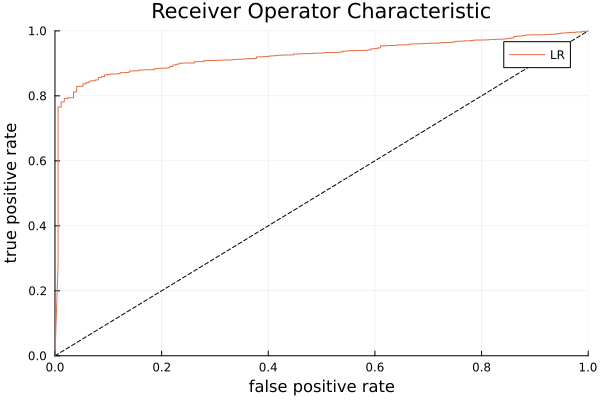

In [705]:
plot(roc, label="LR")

In [706]:
roc = ROC.roc(y_train_pred, y_train, true);
area = ROC.AUC(roc)

0.9220755367467941

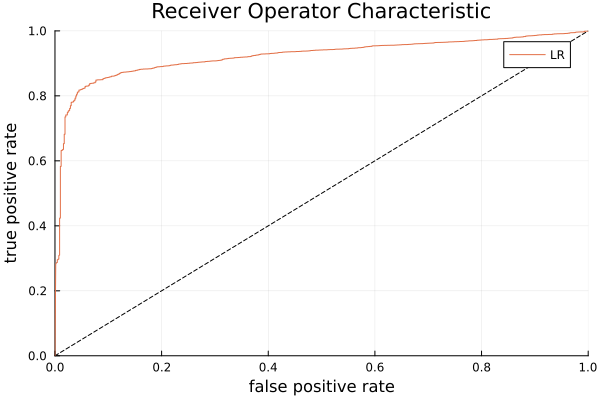

In [700]:
plot(roc, label="LR")


In [ ]:
accuracy

0.8697327233325307

# Optimal Prescriptive Tree

In [678]:
seed = 15095
#import the DataFramea
df = CSV.read("Cleaning/clustering_data.csv", DataFrame);

#Keep the rows where the low estimate is between 0 and 250000 -> 80% of the unsold artwork is in this range
df = df[df[!,"high_estimate"] .< 250000, :];

#Keep only the rows where Christies sold the artwork
#df = df[df[!,"Christies"] .== 1, :];
#df = df[df[!,"Sothebys"] .== 1, :];

#Keep rows where Christies OR Sothebys sold the artwork
df = df[df[!,"Christies"] .== 1 .| df[!,"Sothebys"] .== 1, :];

#Keep rows where the sales price is at most twice the high estimate
df = df[df[!,"sales_price"] .<= 1.35*df[!,"high_estimate"], :];

#Keep only rows where the sales price is less than 500,000
#df = df[df[!,"sales_price"] .< 500000, :];

df_sold = df[df[!,"sold"] .== 1, :]
df_unsold = df[df[!,"sold"] .== 0, :];

#df_sold_limited = df_sold[sample(1:nrow(df_sold), 6360, replace=false), :] #select only some sold rows to get a balanced dataset 
#df_opt = vcat(df_unsold, df_sold_limited) #concatenate the two dataframes

df_opt = vcat(df_unsold, df_sold) #concatenate the two dataframes

#Distribution of sold column - Check it worked
countmap(df_opt[!,"sold"])

Dict{Int64, Int64} with 1 entry:
  1 => 3358

In [381]:
#write this dataframe to a csv file
#CSV.write("Cleaning/optimalPrescriptiveTree_Pic_China.csv", df_opt)

In [679]:
seed = 12345
X = df_opt[:, Not(:sold)];
#X = X[:, Not(:sales_price)];
X = X[:, Not(:high_estimate)];
X = X[:, Not(:low_estimate)];

y = df_opt.sold #outcome -> sold or not
t = df_opt.high_estimate; #treatments -> prices -> low estimate

In [680]:
(train_X, train_t, train_y), (test_X, test_t, test_y) = IAI.split_data(
    :policy_maximize, X, t, y, train_proportion=0.5, seed=seed);

In [681]:
train_t_discrete = round.(train_t ./ 5000, digits=0) .* 5000 #discretize the prices to the nearest 5k
train_t_discrete;

In [682]:
# Recover real revenues from sales_price
train_y_revenue= train_X.sales_price
test_y_revenue= test_X.sales_price

# Remove sales_price from the data
train_X = train_X[:, Not(:sales_price)]
test_X = test_X[:, Not(:sales_price)];

In [683]:
prescriptive_grid = IAI.GridSearch(
    IAI.OptimalTreePrescriptionMaximizer(
      random_seed=seed,
    ),
    max_depth=4:8,
)
#train_y_revenue = train_y .* train_t #revenue, which is prices times whether the product was purchased or not
IAI.fit!(prescriptive_grid, train_X, train_t_discrete, train_y_revenue)

All Grid Results:

 Row │ max_depth  cp          train_score  valid_score  rank_valid_score
     │ Int64      Float64     Float64      Float64      Int64
─────┼───────────────────────────────────────────────────────────────────
   1 │         4  0.0119068      0.602611   -2.2573e6                  1
   2 │         5  0.0161261      0.64576    -2.65679e6                 2
   3 │         6  0.0104472      0.663438   -3.50859e6                 3
   4 │         7  0.00960137     0.661634   -3.75976e6                 4
   5 │         8  0.00897073     0.676276   -4.09452e6                 5

Best Params:
  cp => 0.011906834280585366
  max_depth => 4

Best Model - Fitted OptimalTreePrescriptionMaximizer:
  1) Split: dated < 0.5
    2) Split: painting < 0.5
      3) Split: signed < 0.5
        4) Prescribe: 235000.0, 108 points, error 0.0002415
        5) Prescribe: 245000.0, 250 points, error 0.0002473
      6) Split: width < 25.1
        7) Split: area < 483.4
          8) Prescribe: 210000.0, 235 points, error 0.0004649
          9) Prescribe: 225000.0, 55 points, error 0.0003028
        10) Prescribe: 250000.0, 273 points, error 0.0002685
    11) Split: United States of America < 0.5
      12) Split: aspect_ratio < 0.665
        13) Prescribe: 210000.0, 56 points, error 0.0003606
        14) Split: area < 890.8
          15) Prescribe: 245000.0, 376 points, error 0.0003043
          16) Prescribe: 250000.0, 154 points, error 0.000225
      17) Prescribe: 235000.0, 172 points, error 0.000219

In [684]:
t_options = collect(0:5000:250000) #range from min to max in 500 k increments
t_options;

reward_lnr = IAI.NumericClassificationRewardEstimator(
    outcome_estimator=IAI.XGBoostClassifier(num_round=10),
    outcome_insample_num_folds=2,
    reward_estimator=:direct_method,
    estimation_kernel_bandwidth=1,
    random_seed=seed,
)

function get_rewards(reward_lnr, X, t, y, t_options)
  predictions, score = IAI.fit_predict!(reward_lnr, X, t, y, t_options,
                                        outcome_score_criterion=:auc)
  rewards = predictions[:reward]
  for t in t_options
    rewards[!, Symbol(t)] = round.(rewards[!, Symbol(t)] .* t, digits=3)
  end
  rewards, score
end
train_rewards, train_reward_score = get_rewards(reward_lnr, train_X, train_t,
                                                train_y, t_options)
train_rewards;

LoadError: ArgumentError: `outcomes` must be 0/1 or false/true when estimating rewards for classification outcomes

In [673]:
test_rewards, test_reward_score = get_rewards(reward_lnr, test_X, test_t,
                                              test_y, t_options)
test_rewards;

In [674]:
function evaluate(recommendations, outcomes, actual_revenue)
    n = length(recommendations)
    pred_revenue = [outcomes[i, recommendations[i]] for i in 1:n]
    improvement = mean(pred_revenue .- actual_revenue) / mean(actual_revenue)
  end
  
  # Get revenue observed for test set in reality
  test_revenue_iai = test_y .* test_t;
  test_revenue_r = test_y_revenue;
  

In [675]:
recommendations_pres = Symbol.(round.(Int, IAI.predict(prescriptive_grid, test_X)[1]))
evaluate(recommendations_pres, test_rewards, test_revenue_iai)

1.0570687742186016

In [676]:
recommendations_pres = Symbol.(round.(Int, IAI.predict(prescriptive_grid, test_X)[1]))
evaluate(recommendations_pres, test_rewards, test_revenue_r)

1.1216427112353755

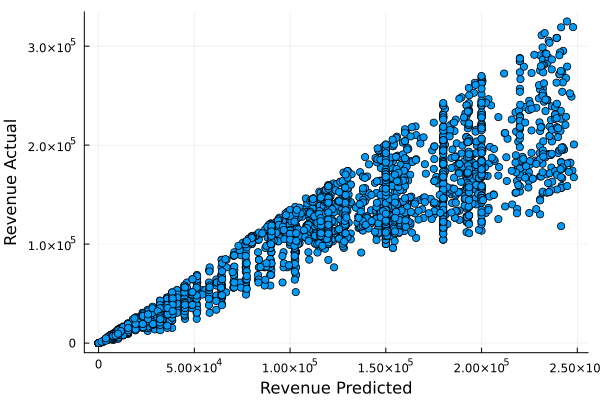

In [677]:
using Plots
#plot test_revenue_iai vs test_revenue_r
plot(test_revenue_iai, test_revenue_r, seriestype=:scatter, xlabel="Revenue Predicted", ylabel="Revenue Actual", legend=false)

In [393]:
#how many test_revenue_r are 0?
sum(test_revenue_r .== 0)

314

Numeric treatment